In [1]:
import os, sys
os.chdir(sys.path[0])
import random
import time
from tqdm import tqdm

import torch
import numpy as np
import torch.nn as nn

import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import style
import cv2 as cv


In [2]:
import NeuralNet_DEEP
import importlib

# Reload module if there's any changes to NeuralNet_DEEP
importlib.reload(NeuralNet_DEEP)

print("GPU Avaialble:", torch.cuda.device_count())
if torch.cuda.is_available():
    device = torch.device("cuda:0") # index 0 just means your first GPU
    print("CUDA is available. Running on GPU")
else:
    device = torch.device("cpu")
    print("CUDA is unavailable. Running on CPU")



# when we use any tensor, just do .to(device) to every tensors. We're going to have to 
# per batch of data given to train, give it to the GPU as your dataset might be too big for
# just one lump sum.
# you can also do the actual quering on the CPU, jsut training on GPU

# Initialise Variables
net = NeuralNet_DEEP.NeuralNet().to(device)

print("NET INFO:")
net.showNetworkDetails()

GPU Avaialble: 1
CUDA is available. Running on GPU
NET INFO:
================ DETAILS ================
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(128, 280, kernel_size=(3, 3), stride=(1, 1))
Linear(in_features=10080, out_features=1200, bias=True)
Linear(in_features=1200, out_features=120, bias=True)
Linear(in_features=120, out_features=6, bias=True)
================ DETAILS ================


In [3]:
# PREPARE TRAINING DATA SECTION [assuming Width and Height are the same]
IMG_SIZE = NeuralNet_DEEP.IMG_WIDTH
LABELS = NeuralNet_DEEP.DRONE_LABELS

training_data = np.load("training_data.npy", allow_pickle=True)

# scramble again 2 times
np.random.shuffle(training_data)
np.random.shuffle(training_data)

data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=[-10,+10]),
        transforms.ToTensor(),
])


def transform_numpy(x):
        # Data Augmentation
        if random.random() > 0.5:
                padding = random.randrange(10, 20, 2)

                x = F.pad(input=x, pad=(padding, padding, padding, padding), value=0, mode="constant").numpy()
                x = torch.Tensor(cv.resize(x, (IMG_SIZE, IMG_SIZE), interpolation=cv.INTER_CUBIC))

                # x = data_transforms(x)
                
                return x
                
        return x


# Optimiser and Loss Computation
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

y = torch.Tensor([i[1] for i in training_data])

X = torch.Tensor([i[0] for i in training_data])

for i in range(len(X)):
        X[i] = transform_numpy(X[i])

# X = [i[0]for i in training_data]

X = X.view(-1, IMG_SIZE, IMG_SIZE)


X = X/255.0 # scaling the imagery (pixels are between 0-255, want them to be 0-1)


# 90% will be training data, 10% will be testing data
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]



C:\Users\Bryan\AppData\Local\Temp\ipykernel_9488\3885260423.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  y = torch.Tensor([i[1] for i in training_data])


In [4]:
def fwd_pass(X,y,train=False):
    if not train:
        net.zero_grad()
    
    # passing training batch dataset is passing to forward method in Net class
    outputs = net(X)
    matches = []
    
    matches = [torch.argmax(i)==torch.argmax(j) for i,j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)    
    
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    
    return acc, loss

In [5]:
def test(size=32):
    
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,IMG_SIZE,IMG_SIZE).to(device), y.to(device))
    
    return val_acc, val_loss


In [6]:
def trainModel():
    BATCH_SIZE = 320
    EPOCHS = 6
    
    with open("model.log", "w") as f:
        for epoch in range(EPOCHS):
            #print("EPOCH:", epoch)
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,IMG_SIZE,IMG_SIZE).to(device)

                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                # Training accuracy and loss
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                # for every 5 steps calculate loss
                if i % 5 == 0:
                    # Validation accuracy and loss
                    val_acc, val_loss = test()
                    
                    f.write(f"{round(time.time(),3)}, { round(float(acc),2) }, {round(float(loss),2)}, {round(float(val_acc),2)}, {round(float(val_loss),2)}\n")
trainModel()

100%|██████████| 34/34 [00:20<00:00,  1.67it/s]


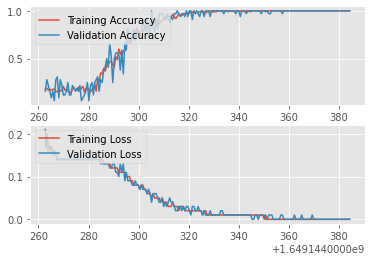

In [7]:
style.use("ggplot")

def createGraph():
    contents = open("model.log", "r").read().split("\n")
    
    times = []
    accuracies = []
    losses = []
    
    val_accs = []
    val_losses = []

    for c in contents:
        if c:
            timestamp, acc, loss, val_acc, val_loss = c.split(",")
            
            times.append(float(timestamp)) 
            accuracies.append(float(acc)) 
            losses.append(float(loss)) 
            val_accs.append(float(val_acc)) 
            val_losses.append(float(val_loss)) 
    
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0))
    # ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    
    ax1.plot(times, accuracies, label="Training Accuracy")
    ax1.plot(times, val_accs, label="Validation Accuracy")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="Training Loss")
    ax2.plot(times, val_losses, label="Validation Loss")
    ax2.legend(loc=2)
    
    plt.show()
    
createGraph()

tensor([[-0.0015, -0.0137,  1.1308, -0.0172,  0.0126, -0.0311]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
2
PEACE


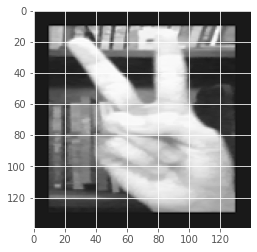

In [8]:
# print(torch.argmax(net(test_X[0].view(-1,1,50,50))) )
# print(torch.argmax(test_y[0]))
# print((net(test_X[0].view(-1,1,50,50))))
TEST = random.randint(1,500)

answer = -1
prediction = net(test_X[TEST].view(-1,1,IMG_SIZE,IMG_SIZE).to(device))
print(prediction)


for i in prediction:
    for j in i:
        if(j.item() > 0.5):
            answer = torch.argmax(prediction).item()
            break

print(answer)
if answer < 0:
    print("UNKNOWN")
else:
    print(LABELS[answer])

plt.imshow(test_X[TEST].view(IMG_SIZE,IMG_SIZE), cmap="gray")
plt.show()

In [9]:
torch.save(net.state_dict(), "model.pth")